In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

### Import data

In [2]:
mta_data = pd.read_pickle('mta_2018')

### Clean columns

In [3]:
# reset mta data index
mta_data.reset_index(drop=True,inplace=True)

# rename column EXITS
mta_data.rename(columns={'EXITS                                                               ':'EXITS'},inplace=True)

In [4]:
# Create DateTime column
mta_data['DATETIME'] = pd.to_datetime(mta_data.DATE + ' ' + mta_data.TIME)
mta_data['DATE']= pd.to_datetime(mta_data['DATE'])

# Find median_hour (center of the time slot)
# Corresponds to 2am, 6am, 10am, 14=2pm,...
mta_data['HOUR'] = (((mta_data['DATETIME'].diff()/2).shift(-1) + mta_data['DATETIME']).dt.hour)
mta_data.dropna(how='any',subset=['HOUR'],inplace=True)
mta_data['HOUR'] = mta_data['HOUR'].astype('int')

# Create Day of Week from newly create DateTime column
mta_data['WEEKDAY'] = mta_data['DATETIME'].dt.day_name()
# Create day_of_week column
mta_data['dow'] = mta_data['DATETIME'].apply(lambda x: x.weekday())


In [5]:
# Create Unique Daily ID for each turnstile
mta_data['UNIQUEID'] = mta_data['STATION'] + '_' + mta_data['UNIT'] + '_' + mta_data['C/A'] \
+ '_' + mta_data['SCP']

### Find entries for each row

In [6]:
# clean ENTRIES/EXITS as they are cumulative data
mta_data['ENTRYDIFF'] = mta_data.ENTRIES.diff()
mta_data['EXITDIFF'] = mta_data.EXITS.diff()
mta_data = mta_data[(mta_data['ENTRYDIFF'] < 100000) & (mta_data['ENTRYDIFF'] > 0)]
mta_data = mta_data[(mta_data['EXITDIFF'] < 100000) & (mta_data['EXITDIFF'] > 0)]
mta_data['TRAFFIC'] = mta_data['ENTRYDIFF'] + mta_data['EXITDIFF']

In [7]:
mta_data['TRAFFIC'].min(), mta_data['TRAFFIC'].mean(), mta_data['TRAFFIC'].max()

(2.0, 404.47821081453253, 159174.0)

In [8]:
# Find time_span (hr) between each row
# Note that most are 4.0 hrs but some are not
mta_data['DURATION'] = mta_data.DATETIME.diff().apply(lambda x: x.total_seconds()/3600)

In [9]:
# Find avg_entries (entries per hour)
mta_data['AVG_TRAFFIC'] = mta_data['TRAFFIC']/ mta_data['DURATION']

In [10]:
# Drop unnecessary columns
mta_data.drop(columns=['DATE','TIME','C/A','UNIT','SCP','LINENAME','DESC','ENTRIES','EXITS'],inplace=True)

In [11]:
mta_data.reset_index(inplace=True)
mta_data

,index,STATION,DIVISION,DATETIME,HOUR,WEEKDAY,dow,UNIQUEID,ENTRYDIFF,EXITDIFF,TRAFFIC,DURATION,AVG_TRAFFIC
0,1,59 ST,BMT,2018-05-12 04:00:00,6,Saturday,5,59 ST_R051_A002_02-00-00,19.0,5.0,24.0,NaN,NaN
1,2,59 ST,BMT,2018-05-12 08:00:00,10,Saturday,5,59 ST_R051_A002_02-00-00,19.0,31.0,50.0,4.0,12.50
2,3,59 ST,BMT,2018-05-12 12:00:00,14,Saturday,5,59 ST_R051_A002_02-00-00,105.0,85.0,190.0,4.0,47.50
3,4,59 ST,BMT,2018-05-12 16:00:00,18,Saturday,5,59 ST_R051_A002_02-00-00,219.0,49.0,268.0,4.0,67.00
4,5,59 ST,BMT,2018-05-12 20:00:00,22,Saturday,5,59 ST_R051_A002_02-00-00,297.0,50.0,347.0,4.0,86.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
624525,788280,RIT-ROOSEVELT,RIT,2018-06-08 01:00:00,3,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,165.0,1.0,166.0,4.0,41.50
624526,788281,RIT-ROOSEVELT,RIT,2018-06-08 05:00:00,7,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,5.0,1.0,6.0,4.0,1.50
624527,788282,RIT-ROOSEVELT,RIT,2018-06-08 09:00:00,11,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,330.0,9.0,339.0,4.0,84.75
624528,788283,RIT-ROOSEVELT,RIT,2018-06-08 13:00:00,15,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,438.0,7.0,445.0,4.0,111.25


### Choose station

In [12]:
# Choose penn station data
penn_df = mta_data[mta_data.STATION == '34 ST-PENN STA'].iloc[1:].reset_index()

# Filter for entries between 0 and 3000
# Outliers come from switching to next turnstiles (should be the same as dropping first rows of each turnstile)
# Filter out the negative values of avg_entries
# (should be the same as dropping first value of each turnstile on a new day)
penn_filter = penn_df[(penn_df.TRAFFIC<100000) & (penn_df.TRAFFIC>0)].copy()

Check if the value of entries make sense:

In [13]:
penn_filter.TRAFFIC.min(),penn_filter.TRAFFIC.mean(),penn_filter.TRAFFIC.max()

(2.0, 492.9517246061923, 3541.0)

In [14]:
# Check if values of avg_entries make sense
# Found negative values: happens when switching to next turnsiles
penn_filter['AVG_TRAFFIC'].min(), penn_filter['AVG_TRAFFIC'].mean(), penn_filter['AVG_TRAFFIC'].max()

(-3.75, 123.38552558839368, 885.25)

In [15]:
penn_filter = penn_filter[penn_filter['AVG_TRAFFIC'] > 0]
penn_filter['AVG_TRAFFIC'] = penn_filter['AVG_TRAFFIC'].astype(int)

In [16]:
# There are 92 turnstiles in Penn station?
penn_filter.UNIQUEID.nunique()

92

In [17]:
penn_filter.AVG_TRAFFIC.min(),penn_filter.AVG_TRAFFIC.mean(),penn_filter.AVG_TRAFFIC.max()

(0, 126.17610194276165, 885)

In [18]:
penn_filter

,level_0,index,STATION,DIVISION,DATETIME,HOUR,WEEKDAY,dow,UNIQUEID,ENTRYDIFF,EXITDIFF,TRAFFIC,DURATION,AVG_TRAFFIC
0,41375,50310,34 ST-PENN STA,IND,2018-05-12 08:00:00,10,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,28.0,43.0,71.0,4.0,17
1,41376,50311,34 ST-PENN STA,IND,2018-05-12 12:00:00,14,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,95.0,116.0,211.0,4.0,52
2,41377,50312,34 ST-PENN STA,IND,2018-05-12 16:00:00,18,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,150.0,150.0,300.0,4.0,75
3,41378,50313,34 ST-PENN STA,IND,2018-05-12 20:00:00,22,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,105.0,157.0,262.0,4.0,65
4,41379,50314,34 ST-PENN STA,IND,2018-05-13 00:00:00,2,Sunday,6,34 ST-PENN STA_R012_N067_00-00-00,41.0,56.0,97.0,4.0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14723,572443,722622,34 ST-PENN STA,IRT,2018-06-08 02:00:00,4,Friday,4,34 ST-PENN STA_R293_R142_01-06-01,74.0,43.0,117.0,4.0,29
14724,572444,722624,34 ST-PENN STA,IRT,2018-06-08 10:00:00,12,Friday,4,34 ST-PENN STA_R293_R142_01-06-01,100.0,498.0,598.0,8.0,74
14725,572445,722625,34 ST-PENN STA,IRT,2018-06-08 14:00:00,16,Friday,4,34 ST-PENN STA_R293_R142_01-06-01,166.0,283.0,449.0,4.0,112
14726,572446,722626,34 ST-PENN STA,IRT,2018-06-08 18:00:00,20,Friday,4,34 ST-PENN STA_R293_R142_01-06-01,244.0,416.0,660.0,4.0,165


In [19]:
# Sum over all turnstiles
penn_total = penn_filter.groupby(["dow","HOUR"])['AVG_TRAFFIC'].sum().reset_index()
# penn_total

In [20]:
penn_total.AVG_TRAFFIC.sum()/28 # avg_entries is 35144!

64714.82142857143

In [21]:
# Compare group station and sum
penn_total_test = penn_filter.groupby(["STATION"])['AVG_TRAFFIC'].sum().reset_index()
penn_total_test.AVG_TRAFFIC.sum()/28

64714.82142857143

In [22]:
# Average over day
penn_total_byday = penn_total.groupby("HOUR")['AVG_TRAFFIC'].mean().reset_index()
penn_total_byday['AVG_TRAFFIC'] = penn_total_byday['AVG_TRAFFIC'].astype(int)
penn_total_byday

,HOUR,AVG_TRAFFIC
0,0,15235
1,2,18824
2,3,1100
3,4,3964
4,5,80
5,6,2543
6,7,382
7,8,1347
8,10,27822
9,11,3002


<ipython-input-23-ba68365d7de8>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['10k','20k','30k','40k','50k','60k','70k'])


[Text(0, 0.0, '10k'),
 Text(0, 10000.0, '20k'),
 Text(0, 20000.0, '30k'),
 Text(0, 30000.0, '40k'),
 Text(0, 40000.0, '50k'),
 Text(0, 50000.0, '60k'),
 Text(0, 60000.0, '70k'),
 Text(0, 70000.0, '')]

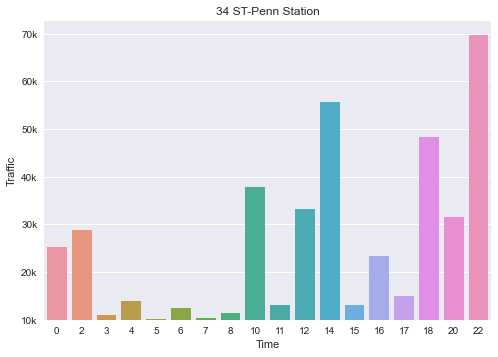

In [23]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_total_byday)
ax.set_title('34 ST-Penn Station')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic')
ax.set_yticklabels(['10k','20k','30k','40k','50k','60k','70k'])

Text(0, 0.5, 'Traffic')

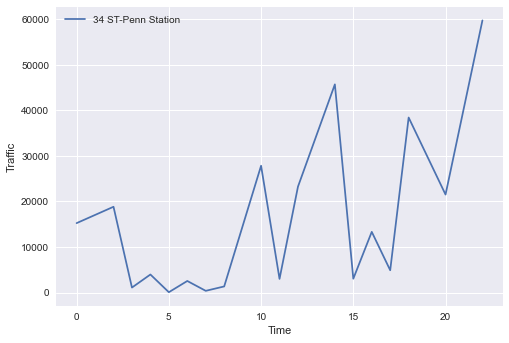

In [24]:
# Same data shown in lineplot (can overlap with data from other stations)
ax = sns.lineplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_total_byday, label='34 ST-Penn Station')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Traffic')

In [25]:
# Day of week daily entries
# Sum over all turnstiles
# penn_total = penn_filter2.groupby(["day_of_week","median_hour"])['avg_entries'].sum().reset_index()

# Sum over hours for one day
penn_total_byweek = penn_total.groupby("dow")['AVG_TRAFFIC'].sum().reset_index()
penn_total_byweek['AVG_TRAFFIC'] = penn_total_byweek['AVG_TRAFFIC'].astype(int)
penn_total_byweek

,dow,AVG_TRAFFIC
0,0,260867
1,1,315699
2,2,322622
3,3,328071
4,4,311001
5,5,132181
6,6,141574


[Text(0, 0, 'Mon'),
 Text(1, 0, 'Tue'),
 Text(2, 0, 'Wed'),
 Text(3, 0, 'Thu'),
 Text(4, 0, 'Fri'),
 Text(5, 0, 'Sat'),
 Text(6, 0, 'Sun')]

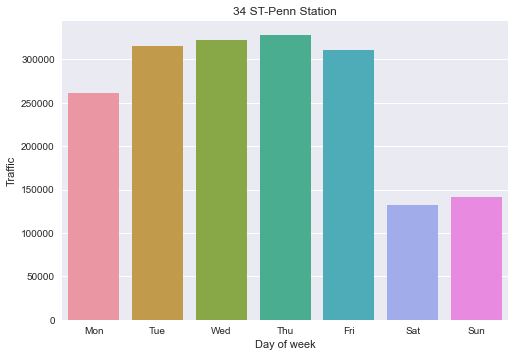

In [26]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='dow', y= 'AVG_TRAFFIC', data = penn_total_byweek)
ax.set_title('34 ST-Penn Station')
ax.set_xlabel('Day of week')
ax.set_ylabel('Traffic')
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
# ax.set_yticklabels(['50k','100k','150k','200k','250k','300k'])

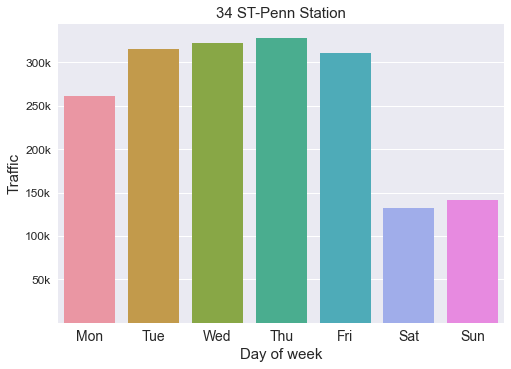

In [27]:
fig, ax = plt.subplots()
ax = sns.barplot(x='dow', y= 'AVG_TRAFFIC', data = penn_total_byweek)
ax.set_title('34 ST-Penn Station',fontsize=15)
ax.set_xlabel('Day of week',fontsize=15)
ax.set_ylabel('Traffic',fontsize=15)
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=14)

ax.set_yticks([5e4,10e4,15e4,20e4,25e4,30e4])
ax.set_yticklabels(['50k','100k','150k','200k','250k','300k'],fontsize=12)
fig.savefig('Traffic_dayofweek.pdf', bbox_inches='tight')

In [28]:
# Check the daily traffic
penn_total_byday.AVG_TRAFFIC.mean(),penn_total_byday.AVG_TRAFFIC.mean()*24

(15782.111111111111, 378770.6666666667)

In [29]:
# weekday/weekend
penn_weekday = penn_filter[penn_filter['dow'] < 5]
penn_weekend = penn_filter[penn_filter['dow'] >= 5]

In [30]:
penn_weekend

,level_0,index,STATION,DIVISION,DATETIME,HOUR,WEEKDAY,dow,UNIQUEID,ENTRYDIFF,EXITDIFF,TRAFFIC,DURATION,AVG_TRAFFIC
0,41375,50310,34 ST-PENN STA,IND,2018-05-12 08:00:00,10,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,28.0,43.0,71.0,4.0,17
1,41376,50311,34 ST-PENN STA,IND,2018-05-12 12:00:00,14,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,95.0,116.0,211.0,4.0,52
2,41377,50312,34 ST-PENN STA,IND,2018-05-12 16:00:00,18,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,150.0,150.0,300.0,4.0,75
3,41378,50313,34 ST-PENN STA,IND,2018-05-12 20:00:00,22,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,105.0,157.0,262.0,4.0,65
4,41379,50314,34 ST-PENN STA,IND,2018-05-13 00:00:00,2,Sunday,6,34 ST-PENN STA_R012_N067_00-00-00,41.0,56.0,97.0,4.0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14694,572414,722593,34 ST-PENN STA,IRT,2018-06-03 06:00:00,8,Sunday,6,34 ST-PENN STA_R293_R142_01-06-01,9.0,7.0,16.0,4.0,4
14695,572415,722594,34 ST-PENN STA,IRT,2018-06-03 10:00:00,12,Sunday,6,34 ST-PENN STA_R293_R142_01-06-01,46.0,67.0,113.0,4.0,28
14696,572416,722595,34 ST-PENN STA,IRT,2018-06-03 14:00:00,16,Sunday,6,34 ST-PENN STA_R293_R142_01-06-01,120.0,173.0,293.0,4.0,73
14697,572417,722596,34 ST-PENN STA,IRT,2018-06-03 18:00:00,20,Sunday,6,34 ST-PENN STA_R293_R142_01-06-01,115.0,271.0,386.0,4.0,96


In [31]:
# penn_weekday_total['AVG_TRAFFIC'].nsmallest(5)

In [32]:
# Weekday data
# Sum over all turnstiles
penn_weekday_total = penn_weekday.groupby(["dow","HOUR"])['AVG_TRAFFIC'].sum().reset_index()
# Average over day
penn_weekday_total_byday = penn_weekday_total.groupby("HOUR")['AVG_TRAFFIC'].mean().reset_index()
penn_weekday_total_byday

,HOUR,AVG_TRAFFIC
0,0,18276.50
1,2,18938.80
2,3,1100.00
3,4,3813.00
4,5,80.00
5,6,2294.40
6,7,382.00
7,8,1480.00
8,10,36911.00
9,11,3002.00


Text(0, 0.5, 'Traffic')

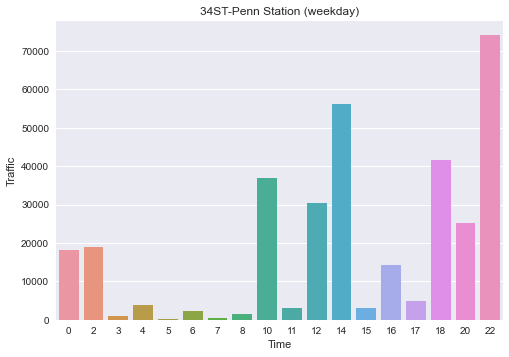

In [33]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekday_total_byday)
ax.set_title('34ST-Penn Station (weekday)')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic')

In [34]:
# Weekend data
# Sum over all turnstiles
penn_weekend_total = penn_weekend.groupby(["dow","HOUR"])['AVG_TRAFFIC'].sum().reset_index()
# Average over day
penn_weekend_total_byday = penn_weekend_total.groupby("HOUR")['AVG_TRAFFIC'].mean().reset_index()
penn_weekend_total_byday

,HOUR,AVG_TRAFFIC
0,0,9153.0
1,2,18254.0
2,4,4724.0
3,6,3789.0
4,8,687.0
5,10,5101.5
6,12,5111.0
7,14,19303.0
8,16,11276.5
9,18,30364.0


<AxesSubplot:xlabel='HOUR', ylabel='AVG_TRAFFIC'>

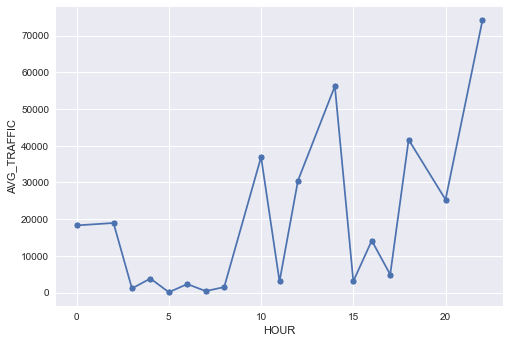

In [35]:
# Try distplot
sns.scatterplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekday_total_byday)
sns.lineplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekday_total_byday)

Text(0, 0.5, 'Traffic')

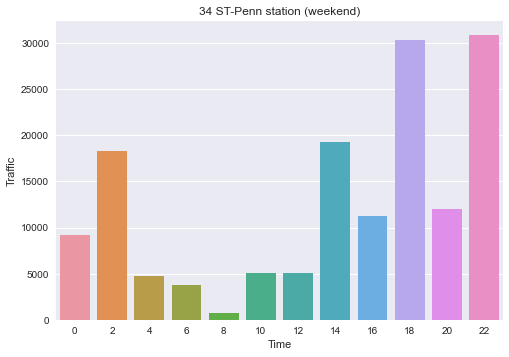

In [36]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekend_total_byday)
ax.set_title('34 ST-Penn station (weekend)')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic')

Text(0, 0.5, 'Traffic')

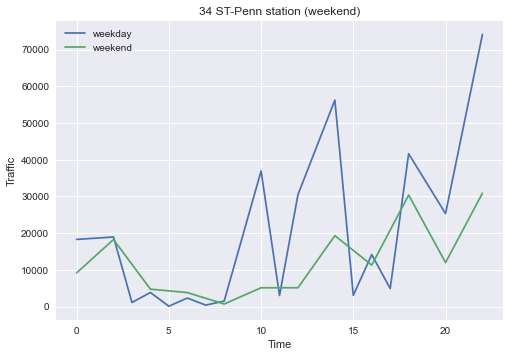

In [37]:
# Plot together for comparison
ax = sns.lineplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekday_total_byday, label='weekday')
ax = sns.lineplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekend_total_byday, label='weekend')
ax.set_title('34 ST-Penn station (weekend)')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic')

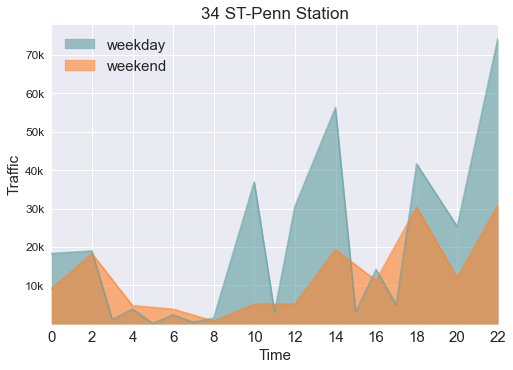

In [38]:
fig, ax = plt.subplots()
temp1 = penn_weekday_total_byday.set_index('HOUR')
temp2 = penn_weekend_total_byday.set_index('HOUR')
temp1["AVG_TRAFFIC"].plot.area(label='weekday',alpha=0.6,color='cadetblue')
temp2["AVG_TRAFFIC"].plot.area(label='weekend',alpha=0.6,color='#FF8229')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Traffic', fontsize=15)
plt.title('34 ST-Penn Station',fontsize=17)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlim([0,22])
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22])
ax.set_yticks([1e4,2e4,3e4,4e4,5e4,6e4,7e4])
ax.set_yticklabels(['10k','20k','30k','40k','50k','60k','70k'])
fig.savefig('Traffic_time.pdf', bbox_inches='tight')

In [39]:
sns.color_palette("husl", 9)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8369430560927636, 0.5495828952802333, 0.1952683223448124),
 (0.6430915736746491, 0.6271955086583126, 0.19381135329796756),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.20582072623426667, 0.6842209016721069, 0.5675558225732941),
 (0.2151139535594307, 0.6700707833028816, 0.7112365203426209),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.731751635642941, 0.5128186367840487, 0.9581005178234921),
 (0.9614880299080136, 0.3909885385134758, 0.8298287106954371)]

### All stations

In [40]:
mta_data

,index,STATION,DIVISION,DATETIME,HOUR,WEEKDAY,dow,UNIQUEID,ENTRYDIFF,EXITDIFF,TRAFFIC,DURATION,AVG_TRAFFIC
0,1,59 ST,BMT,2018-05-12 04:00:00,6,Saturday,5,59 ST_R051_A002_02-00-00,19.0,5.0,24.0,NaN,NaN
1,2,59 ST,BMT,2018-05-12 08:00:00,10,Saturday,5,59 ST_R051_A002_02-00-00,19.0,31.0,50.0,4.0,12.50
2,3,59 ST,BMT,2018-05-12 12:00:00,14,Saturday,5,59 ST_R051_A002_02-00-00,105.0,85.0,190.0,4.0,47.50
3,4,59 ST,BMT,2018-05-12 16:00:00,18,Saturday,5,59 ST_R051_A002_02-00-00,219.0,49.0,268.0,4.0,67.00
4,5,59 ST,BMT,2018-05-12 20:00:00,22,Saturday,5,59 ST_R051_A002_02-00-00,297.0,50.0,347.0,4.0,86.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
624525,788280,RIT-ROOSEVELT,RIT,2018-06-08 01:00:00,3,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,165.0,1.0,166.0,4.0,41.50
624526,788281,RIT-ROOSEVELT,RIT,2018-06-08 05:00:00,7,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,5.0,1.0,6.0,4.0,1.50
624527,788282,RIT-ROOSEVELT,RIT,2018-06-08 09:00:00,11,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,330.0,9.0,339.0,4.0,84.75
624528,788283,RIT-ROOSEVELT,RIT,2018-06-08 13:00:00,15,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,438.0,7.0,445.0,4.0,111.25


In [41]:
mta_data.ENTRYDIFF.max()

99711.0

In [42]:
mta_data = mta_data[(mta_data.ENTRYDIFF < 50000) & (mta_data.EXITDIFF < 50000)]

In [43]:
mta_data

,index,STATION,DIVISION,DATETIME,HOUR,WEEKDAY,dow,UNIQUEID,ENTRYDIFF,EXITDIFF,TRAFFIC,DURATION,AVG_TRAFFIC
0,1,59 ST,BMT,2018-05-12 04:00:00,6,Saturday,5,59 ST_R051_A002_02-00-00,19.0,5.0,24.0,NaN,NaN
1,2,59 ST,BMT,2018-05-12 08:00:00,10,Saturday,5,59 ST_R051_A002_02-00-00,19.0,31.0,50.0,4.0,12.50
2,3,59 ST,BMT,2018-05-12 12:00:00,14,Saturday,5,59 ST_R051_A002_02-00-00,105.0,85.0,190.0,4.0,47.50
3,4,59 ST,BMT,2018-05-12 16:00:00,18,Saturday,5,59 ST_R051_A002_02-00-00,219.0,49.0,268.0,4.0,67.00
4,5,59 ST,BMT,2018-05-12 20:00:00,22,Saturday,5,59 ST_R051_A002_02-00-00,297.0,50.0,347.0,4.0,86.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
624525,788280,RIT-ROOSEVELT,RIT,2018-06-08 01:00:00,3,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,165.0,1.0,166.0,4.0,41.50
624526,788281,RIT-ROOSEVELT,RIT,2018-06-08 05:00:00,7,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,5.0,1.0,6.0,4.0,1.50
624527,788282,RIT-ROOSEVELT,RIT,2018-06-08 09:00:00,11,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,330.0,9.0,339.0,4.0,84.75
624528,788283,RIT-ROOSEVELT,RIT,2018-06-08 13:00:00,15,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,438.0,7.0,445.0,4.0,111.25


In [44]:
mta_data.TRAFFIC.max(),mta_data.TRAFFIC.mean()

(95667.0, 384.2855859318695)

In [45]:
mta_data.groupby(['STATION','dow']).sum()

index  HOUR  ENTRYDIFF  EXITDIFF   TRAFFIC  DURATION  \
STATION   dow                                                            
1 AV      0    78245699  2874    75396.0   84328.0  159724.0     960.0   
          1    77822060  2868    86476.0   97644.0  184120.0     960.0   
          2    87606645  2990    92385.0  100329.0  192714.0     960.0   
          3    78280410  2880    91262.0   99863.0  191125.0     960.0   
          4    78054533  2394    95099.0  102856.0  197955.0     960.0   
...                 ...   ...        ...       ...       ...       ...   
ZEREGA AV 2    45047112  1248    11139.0   10110.0   21249.0     384.0   
          3    45047688  1248    10880.0   10018.0   20898.0     384.0   
          4    45048264  1056    10783.0    9812.0   20595.0     384.0   
          5    37537380  1200     4790.0    4267.0    9057.0   -2300.0   
          6    45045384  1248     4098.0    4251.0    8349.0     384.0   

                AVG_TRAFFIC  
STATION   dow                
1 AV      0    39910.500000  
          1    45992.250000  
          2    53728.127574  
          3    47781.250000  
          4    49473.750000  
...                     ...  
ZEREGA AV 2     5312.250000  
          3     5224.500000  
          4     5148.750000  
          5     2147.904167  
          6     2087.250000  

[2614 rows x 7 columns]

In [46]:
station_daily = mta_data.groupby(['STATION','dow']).sum().groupby('STATION').mean()

In [47]:
station_daily = station_daily['TRAFFIC']
station_daily

STATION
1 AV               168275.142857
103 ST             191194.000000
103 ST-CORONA      122032.142857
104 ST              14719.428571
110 ST              71579.428571
                       ...      
WOODHAVEN BLVD     133748.571429
WOODLAWN            30420.571429
WORLD TRADE CTR    141433.857143
YORK ST             46402.000000
ZEREGA AV           17002.000000
Name: TRAFFIC, Length: 375, dtype: float64

In [48]:
station_daily.index

Index(['1 AV', '103 ST', '103 ST-CORONA', '104 ST', '110 ST', '111 ST',
       '116 ST', '116 ST-COLUMBIA', '121 ST', '125 ST',
       ...
       'WESTCHESTER SQ', 'WHITEHALL S-FRY', 'WHITLOCK AV', 'WILSON AV',
       'WINTHROP ST', 'WOODHAVEN BLVD', 'WOODLAWN', 'WORLD TRADE CTR',
       'YORK ST', 'ZEREGA AV'],
      dtype='object', name='STATION', length=375)

In [49]:
station_daily = pd.DataFrame(station_daily)
station_daily = station_daily.reset_index()
station_daily['TRAFFIC'] = station_daily['TRAFFIC'].astype(int)

In [50]:
station_daily.STATION

0                 1 AV
1               103 ST
2        103 ST-CORONA
3               104 ST
4               110 ST
            ...       
370     WOODHAVEN BLVD
371           WOODLAWN
372    WORLD TRADE CTR
373            YORK ST
374          ZEREGA AV
Name: STATION, Length: 375, dtype: object

In [51]:
station_daily[station_daily.STATION == "JAY ST-METROTEC"]

,STATION,TRAFFIC
251,JAY ST-METROTEC,212736


In [52]:
top10 = station_daily.sort_values('TRAFFIC',ascending=False).reset_index()
top10[top10.STATION == "JAY ST-METROTEC"]

,index,STATION,TRAFFIC
33,251,JAY ST-METROTEC,212736


In [53]:
top10 = station_daily.sort_values('TRAFFIC',ascending=False).reset_index().iloc[0:12]
top10

,index,STATION,TRAFFIC
0,59,34 ST-PENN STA,1037172
1,230,GRD CNTRL-42 ST,865292
2,57,34 ST-HERALD SQ,699565
3,14,14 ST-UNION SQ,687666
4,350,TIMES SQ-42 ST,676000
5,45,23 ST,625180
6,223,FULTON ST,586312
7,65,42 ST-PORT AUTH,566035
8,107,86 ST,525050
9,9,125 ST,477945


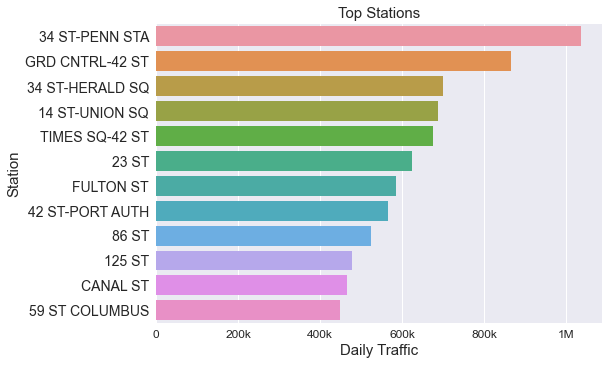

In [54]:
fig, ax = plt.subplots()
ax = sns.barplot(x="TRAFFIC", y= 'STATION', data = top10, orient='h')
ax.set_title('Top Stations',fontsize=15)
ax.set_xlabel('Daily Traffic',fontsize=15)
ax.set_ylabel('Station',fontsize=15)
ax.set_xticks([0,2e5,4e5,6e5,8e5,1e6])
ax.set_xticklabels(['0','200k','400k','600k','800k','1M'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
fig.savefig('Top_station.pdf', bbox_inches='tight')

In [55]:
top33 = station_daily.sort_values('TRAFFIC',ascending=False).reset_index().iloc[0:34]
top33

,index,STATION,TRAFFIC
0,59,34 ST-PENN STA,1037172
1,230,GRD CNTRL-42 ST,865292
2,57,34 ST-HERALD SQ,699565
3,14,14 ST-UNION SQ,687666
4,350,TIMES SQ-42 ST,676000
5,45,23 ST,625180
6,223,FULTON ST,586312
7,65,42 ST-PORT AUTH,566035
8,107,86 ST,525050
9,9,125 ST,477945


In [56]:
top10_plus = top10.iloc[0:11].append(top33.iloc[33])

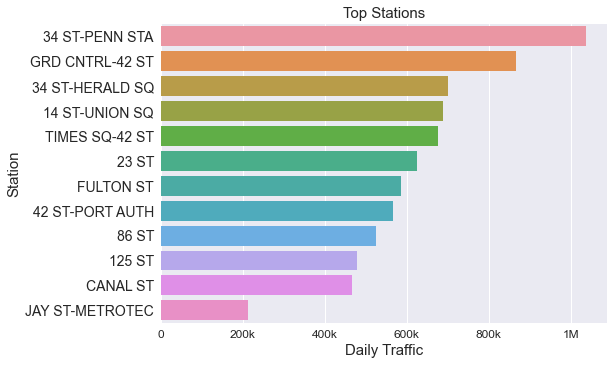

In [57]:
fig, ax = plt.subplots()
ax = sns.barplot(x="TRAFFIC", y= 'STATION', data = top10_plus, orient='h')
ax.set_title('Top Stations',fontsize=15)
ax.set_xlabel('Daily Traffic',fontsize=15)
ax.set_ylabel('Station',fontsize=15)
ax.set_xticks([0,2e5,4e5,6e5,8e5,1e6])
ax.set_xticklabels(['0','200k','400k','600k','800k','1M'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
fig.savefig('Top_station2.pdf', bbox_inches='tight')

### Rainbow plot
Top stations throughout a week

In [58]:
mta_data.tail()

,index,STATION,DIVISION,DATETIME,HOUR,WEEKDAY,dow,UNIQUEID,ENTRYDIFF,EXITDIFF,TRAFFIC,DURATION,AVG_TRAFFIC
624525,788280,RIT-ROOSEVELT,RIT,2018-06-08 01:00:00,3,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,165.0,1.0,166.0,4.0,41.50
624526,788281,RIT-ROOSEVELT,RIT,2018-06-08 05:00:00,7,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,5.0,1.0,6.0,4.0,1.50
624527,788282,RIT-ROOSEVELT,RIT,2018-06-08 09:00:00,11,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,330.0,9.0,339.0,4.0,84.75
624528,788283,RIT-ROOSEVELT,RIT,2018-06-08 13:00:00,15,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,438.0,7.0,445.0,4.0,111.25
624529,788284,RIT-ROOSEVELT,RIT,2018-06-08 17:00:00,19,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,476.0,7.0,483.0,4.0,120.75


In [59]:
station_weekly = mta_data.groupby(['STATION','dow']).sum()/4 # divided by 4 since this is data for 4 weeks

In [60]:
station_weekly

index   HOUR  ENTRYDIFF  EXITDIFF   TRAFFIC  DURATION  \
STATION   dow                                                                
1 AV      0    19561424.75  718.5   18849.00  21082.00  39931.00     240.0   
          1    19455515.00  717.0   21619.00  24411.00  46030.00     240.0   
          2    21901661.25  747.5   23096.25  25082.25  48178.50     240.0   
          3    19570102.50  720.0   22815.50  24965.75  47781.25     240.0   
          4    19513633.25  598.5   23774.75  25714.00  49488.75     240.0   
...                    ...    ...        ...       ...       ...       ...   
ZEREGA AV 2    11261778.00  312.0    2784.75   2527.50   5312.25      96.0   
          3    11261922.00  312.0    2720.00   2504.50   5224.50      96.0   
          4    11262066.00  264.0    2695.75   2453.00   5148.75      96.0   
          5     9384345.00  300.0    1197.50   1066.75   2264.25    -575.0   
          6    11261346.00  312.0    1024.50   1062.75   2087.25      96.0   

                AVG_TRAFFIC  
STATION   dow                
1 AV      0     9977.625000  
          1    11498.062500  
          2    13432.031893  
          3    11945.312500  
          4    12368.437500  
...                     ...  
ZEREGA AV 2     1328.062500  
          3     1306.125000  
          4     1287.187500  
          5      536.976042  
          6      521.812500  

[2614 rows x 7 columns]

In [61]:
station_weekly = pd.DataFrame(station_weekly).reset_index()
station_weekly['TRAFFIC'] = station_weekly['TRAFFIC'].astype(int)

In [62]:
station_weekly

,STATION,dow,index,HOUR,ENTRYDIFF,EXITDIFF,TRAFFIC,DURATION,AVG_TRAFFIC
0,1 AV,0,19561424.75,718.5,18849.00,21082.00,39931,240.0,9977.625000
1,1 AV,1,19455515.00,717.0,21619.00,24411.00,46030,240.0,11498.062500
2,1 AV,2,21901661.25,747.5,23096.25,25082.25,48178,240.0,13432.031893
3,1 AV,3,19570102.50,720.0,22815.50,24965.75,47781,240.0,11945.312500
4,1 AV,4,19513633.25,598.5,23774.75,25714.00,49488,240.0,12368.437500
...,...,...,...,...,...,...,...,...,...
2609,ZEREGA AV,2,11261778.00,312.0,2784.75,2527.50,5312,96.0,1328.062500
2610,ZEREGA AV,3,11261922.00,312.0,2720.00,2504.50,5224,96.0,1306.125000
2611,ZEREGA AV,4,11262066.00,264.0,2695.75,2453.00,5148,96.0,1287.187500
2612,ZEREGA AV,5,9384345.00,300.0,1197.50,1066.75,2264,-575.0,536.976042


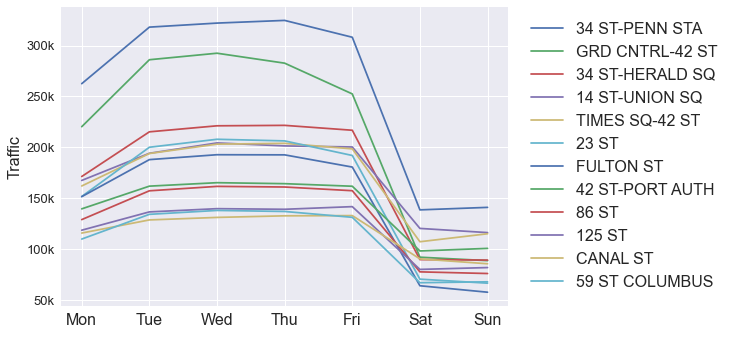

In [63]:
# Plot together for comparison
fig, ax = plt.subplots(1,1)
# Create top_station_list
top_station_list = list(top10.iloc[0:12].STATION)
for x in top_station_list:
    ax = sns.lineplot(x='dow', y= 'TRAFFIC', data = station_weekly[station_weekly.STATION == x], label=str(x))
ax.set_title('',fontsize=17)
ax.set_xlabel(' ',fontsize=15)
ax.set_ylabel('Traffic',fontsize=16)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.set_yticks([0.5e5,1e5,1.5e5,2e5,2.5e5,3e5])
ax.set_yticklabels(['50k','100k','150k','200k','250k','300k'])
plt.legend(fontsize=16,bbox_to_anchor=(1.02, 1), loc=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=13)
fig.savefig('Rainbow_top_station.pdf', bbox_inches='tight')